# House Prices - Playing with Stacking and Ensembling 
### Part - 1 (Public Score - 0.12718)

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (25, 15)

### Read the input file nd display contents

In [4]:
data = pd.read_csv("house price train.csv")
data.drop(columns=['Id'], inplace=True)

In [5]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Price
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### List out all the features in the data that have undefined values

In [6]:
data.columns[data.isna().any()].tolist()

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### Replace the NaN values with mode (Note: Not all NA are invalid)

In [8]:
def cleanNumericalData(df, feature):
    mode = df[feature].dropna().value_counts().index[0]
    df[feature] = df[feature].replace(np.nan, mode)
    return df[feature]

In [9]:
nonObjCols = data.select_dtypes(exclude=['object']).columns
for feature in nonObjCols:
    data[feature] = cleanNumericalData(data, feature)

In [10]:
data['MasVnrType'] = data['MasVnrType'].replace(np.nan, data.MasVnrType.value_counts().index[0])
data['Electrical'] = data['Electrical'].replace(np.nan, data.Electrical.value_counts().index[0])

### One-Hot Encoding

In [11]:
data = pd.get_dummies(data)

In [12]:
columns = data.columns

In [13]:
data = pd.DataFrame(data, columns = columns)

In [15]:
y = data.Price.values

X = data.loc[:, data.columns != 'Price'].values

### Splitting data into Train and Test sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=18)

### Data scaling

In [17]:

inScale = RobustScaler()
outScale = RobustScaler()

X_train = inScale.fit_transform(X_train)
y_train = outScale.fit_transform(y_train.reshape(-1, 1))
X_test = inScale.transform(X_test)
y_test = outScale.transform(y_test.reshape(-1, 1))



MSE: 0.1154
EVS: 0.8834
Score: 0.8832


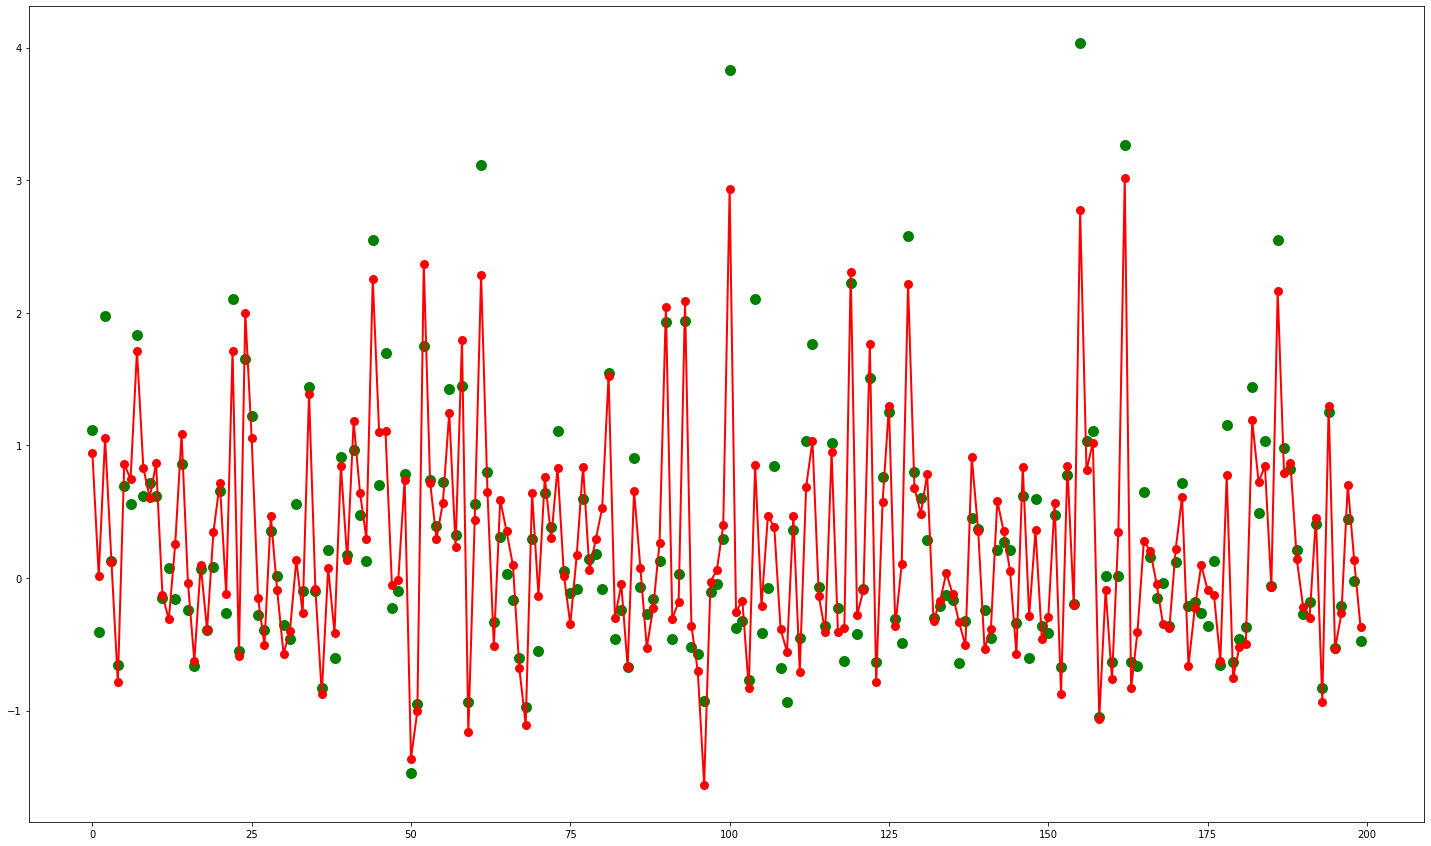

In [18]:
ridge = Ridge(alpha=14).fit(X_train, y_train)

data_predicted = ridge.predict(X_test)

MAX = 200
x = range(len(data_predicted))[0:MAX]
plt.scatter(x,y_test[0:MAX],color='g', linewidths=5)
plt.scatter(x,data_predicted[0:MAX],color='r', linewidths=3)
plt.plot(data_predicted[0:MAX], color = 'r', linewidth=2)

mse = mean_squared_error(y_test, data_predicted)
print("MSE: %.4f" % mse)

evs = explained_variance_score(y_test, data_predicted)
print("EVS: %.4f" % evs)

score = ridge.score(X_test, y_test)
print("Score: %.4f" % score)

MSE: 0.1144
EVS: 0.8844
Score: 0.8842


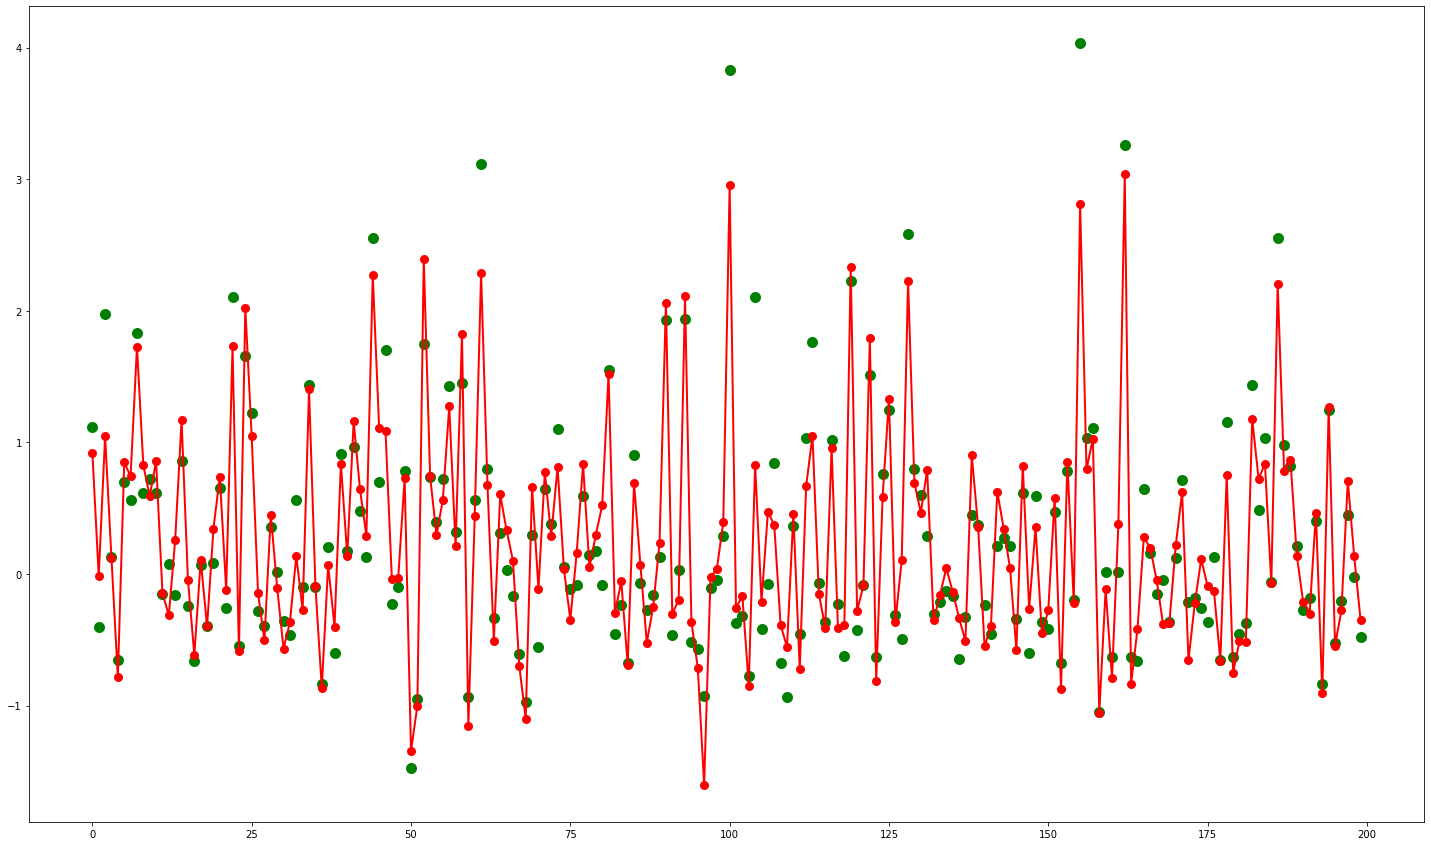

In [19]:
rcv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10]).fit(X_train, y_train)

data_predicted = rcv.predict(X_test)

MAX = 200
x = range(len(data_predicted))[0:MAX]
plt.scatter(x,y_test[0:MAX],color='g', linewidths=5)
plt.scatter(x,data_predicted[0:MAX],color='r', linewidths=3)
plt.plot(data_predicted[0:MAX], color = 'r', linewidth=2)

mse = mean_squared_error(y_test, data_predicted)
print("MSE: %.4f" % mse)

evs = explained_variance_score(y_test, data_predicted)
print("EVS: %.4f" % evs)

score = rcv.score(X_test, y_test)
print("Score: %.4f" % score)

MSE: 0.1268
EVS: 0.8720
Score: 0.8716


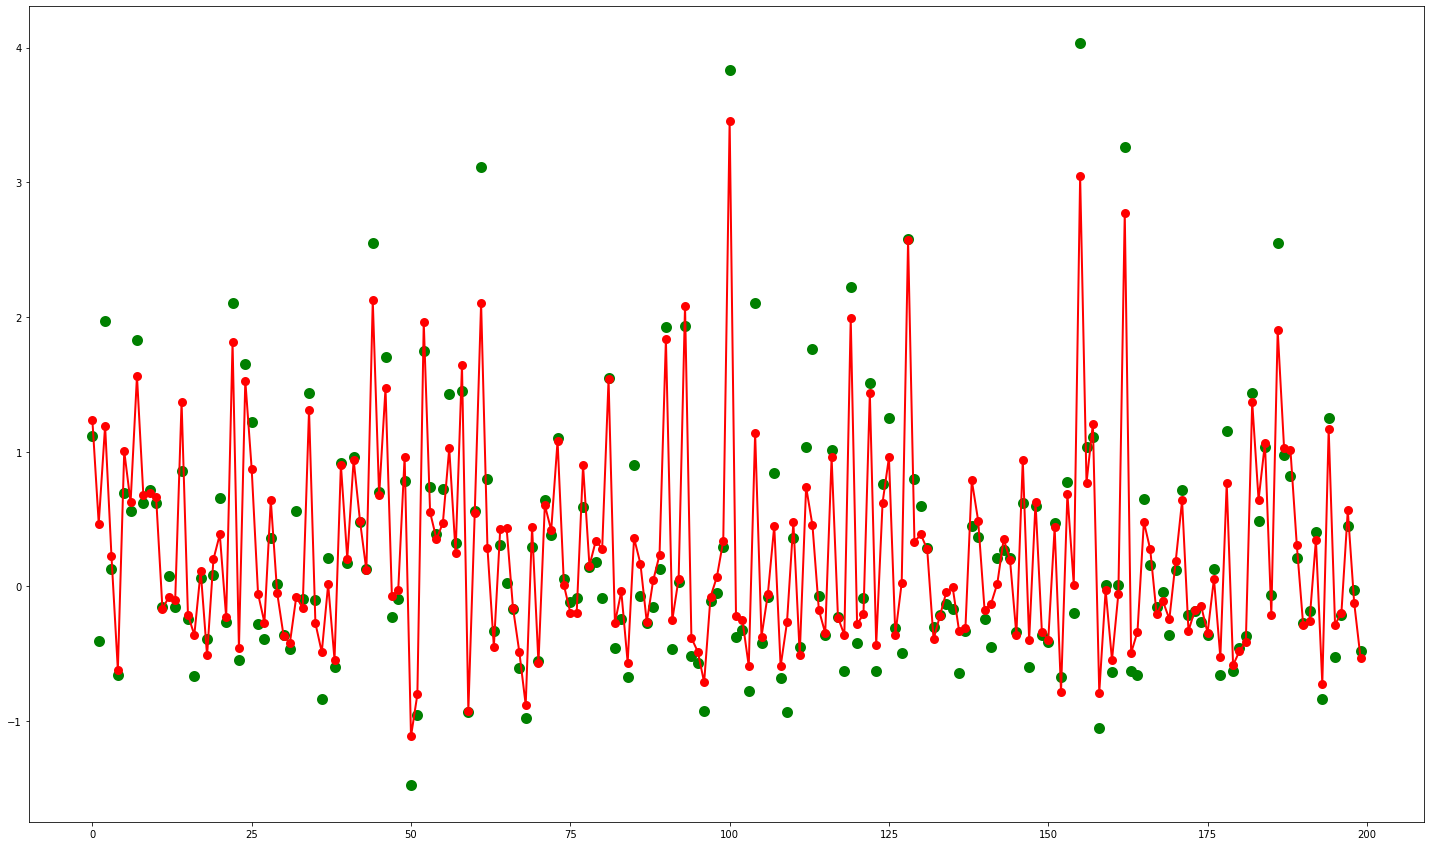

In [20]:
rf = RandomForestRegressor(n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=50, bootstrap=False, random_state=2, n_jobs=-1).fit(X_train, y_train.ravel())

data_predicted = rf.predict(X_test)

MAX = 200
x = range(len(data_predicted))[0:MAX]
plt.scatter(x,y_test[0:MAX],color='g', linewidths=5)
plt.scatter(x,data_predicted[0:MAX],color='r', linewidths=3)
plt.plot(data_predicted[0:MAX], color = 'r', linewidth=2)

mse = mean_squared_error(y_test, data_predicted)
print("MSE: %.4f" % mse)

evs = explained_variance_score(y_test, data_predicted)
print("EVS: %.4f" % evs)

score = rf.score(X_test, y_test)
print("Score: %.4f" % score)

MSE: 0.0841
EVS: 0.9151
Score: 0.9148


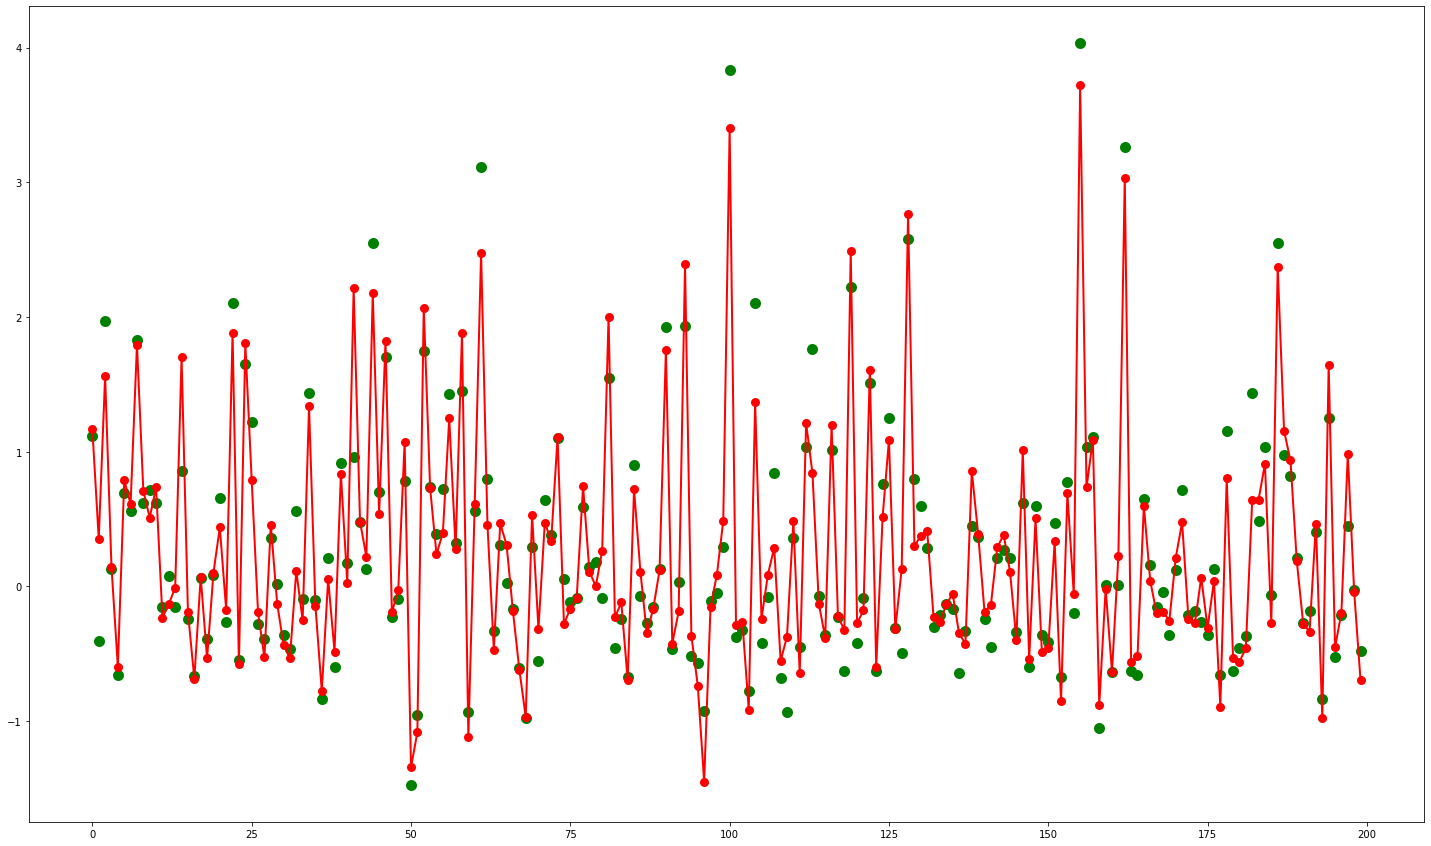

In [21]:
gbr = GradientBoostingRegressor(n_estimators=400,learning_rate=0.1,max_depth=2,subsample=1,random_state=1).fit(X_train, y_train.ravel()) # based on aboved Hyper-tuning

data_predicted = gbr.predict(X_test)

MAX = 200
x = range(len(data_predicted))[0:MAX]
plt.scatter(x,y_test[0:MAX],color='g', linewidths=5)
plt.scatter(x,data_predicted[0:MAX],color='r', linewidths=3)
plt.plot(data_predicted[0:MAX], color = 'r', linewidth=2)

mse = mean_squared_error(y_test, data_predicted)
print("MSE: %.4f" % mse)

evs = explained_variance_score(y_test, data_predicted)
print("EVS: %.4f" % evs)

score = gbr.score(X_test, y_test)
print("Score: %.4f" % score)

MSE: 0.0879
EVS: 0.9111
Score: 0.9109


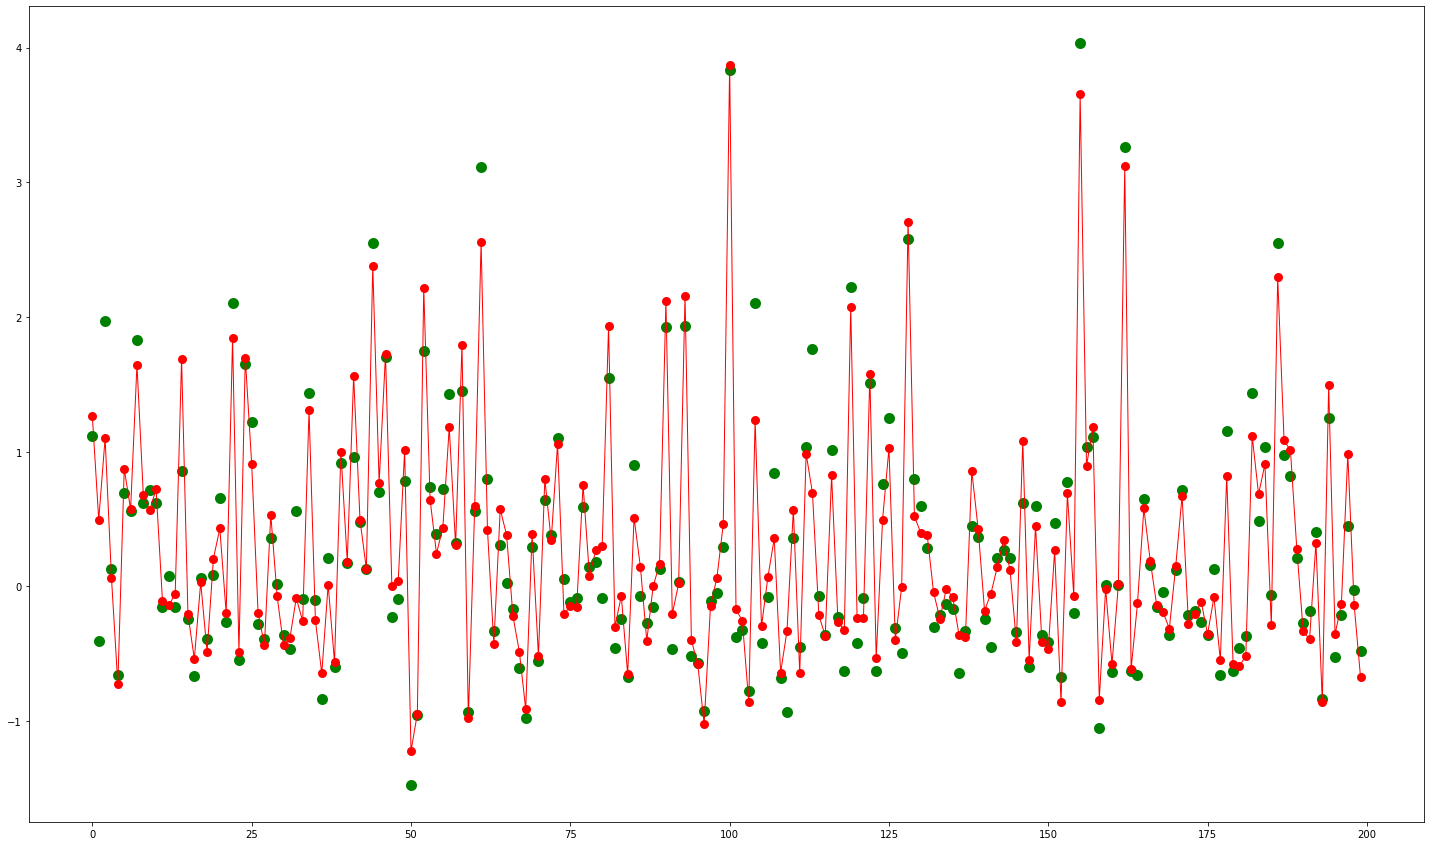

In [22]:
xb = XGBRegressor(colsample_bytree=0.2, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=1000, objective='reg:squarederror', subsample=0.2).fit(X_train, y_train.ravel())

data_predicted = xb.predict(X_test)

MAX = 200
x = range(len(data_predicted))[0:MAX]
plt.scatter(x,y_test[0:MAX],color='g', linewidths=5)
plt.scatter(x,data_predicted[0:MAX],color='r', linewidths=3)
plt.plot(data_predicted[0:MAX], color = 'r', linewidth=1)

mse = mean_squared_error(y_test, data_predicted)
print("MSE: %.4f" % mse)

evs = explained_variance_score(y_test, data_predicted)
print("EVS: %.4f" % evs)

score = xb.score(X_test, y_test)
print("Score: %.4f" % score)

MSE: 0.1167
EVS: 0.8819
Score: 0.8818


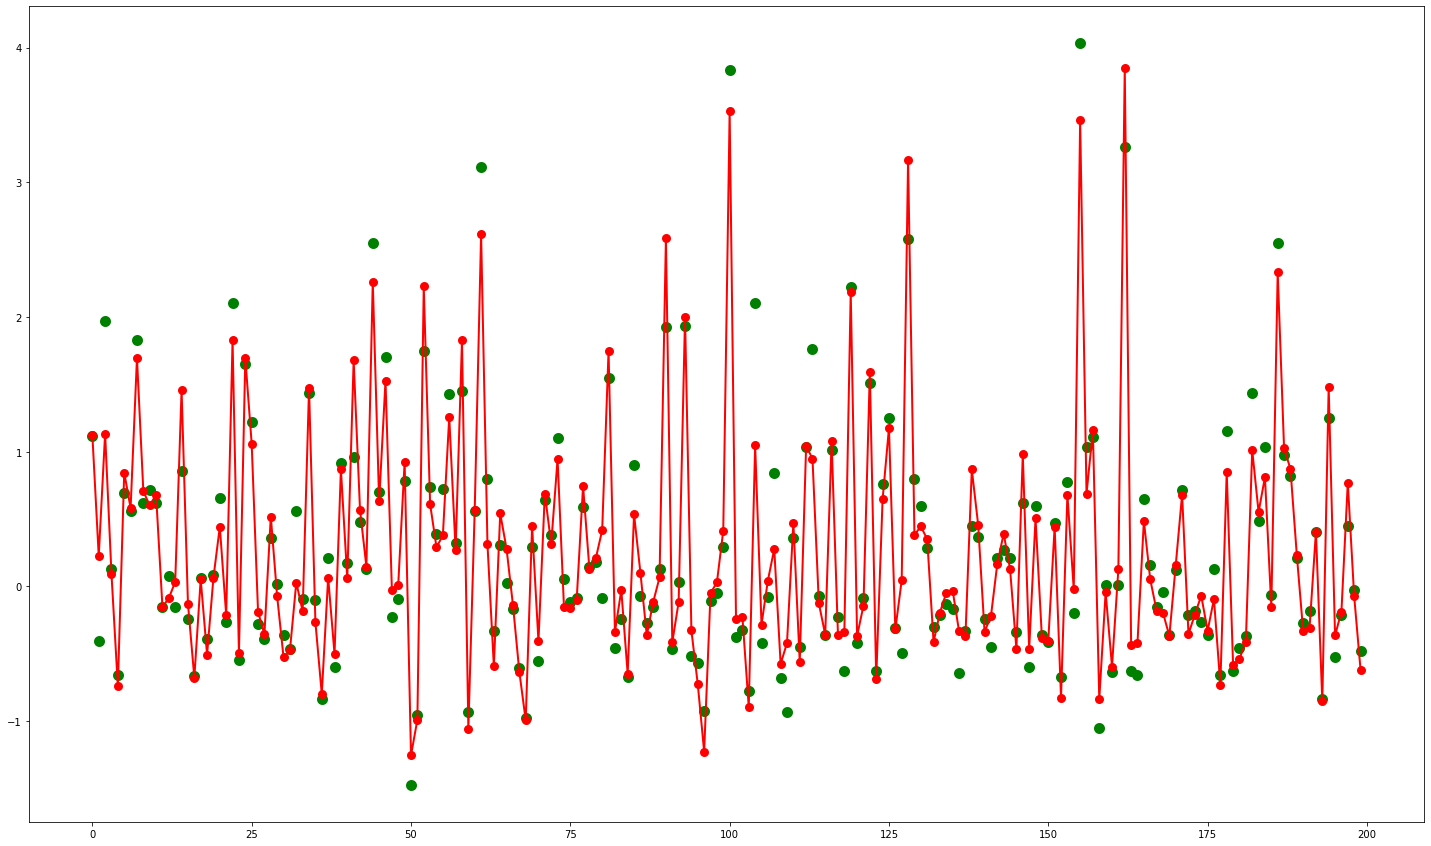

In [23]:
estimators = [('ridge', ridge), ('ridgecv', rcv), ('randomforest', rf), ('gradientboost', gbr), ('xgboost', xb)]
                                                                                                               
sr = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1), cv = 10).fit(X_train, y_train.ravel())

data_predicted = sr.predict(X_test)

MAX = 200
x = range(len(data_predicted))[0:MAX]
plt.scatter(x,y_test[0:MAX],color='g', linewidths=5)
plt.scatter(x,data_predicted[0:MAX],color='r', linewidths=3)
plt.plot(data_predicted[0:MAX], color = 'r', linewidth=2)

mse = mean_squared_error(y_test, data_predicted)
print("MSE: %.4f" % mse)

evs = explained_variance_score(y_test, data_predicted)
print("EVS: %.4f" % evs)

score = sr.score(X_test, y_test)
print("Score: %.4f" % score)

MSE: 0.0921
EVS: 0.9070
Score: 0.9068


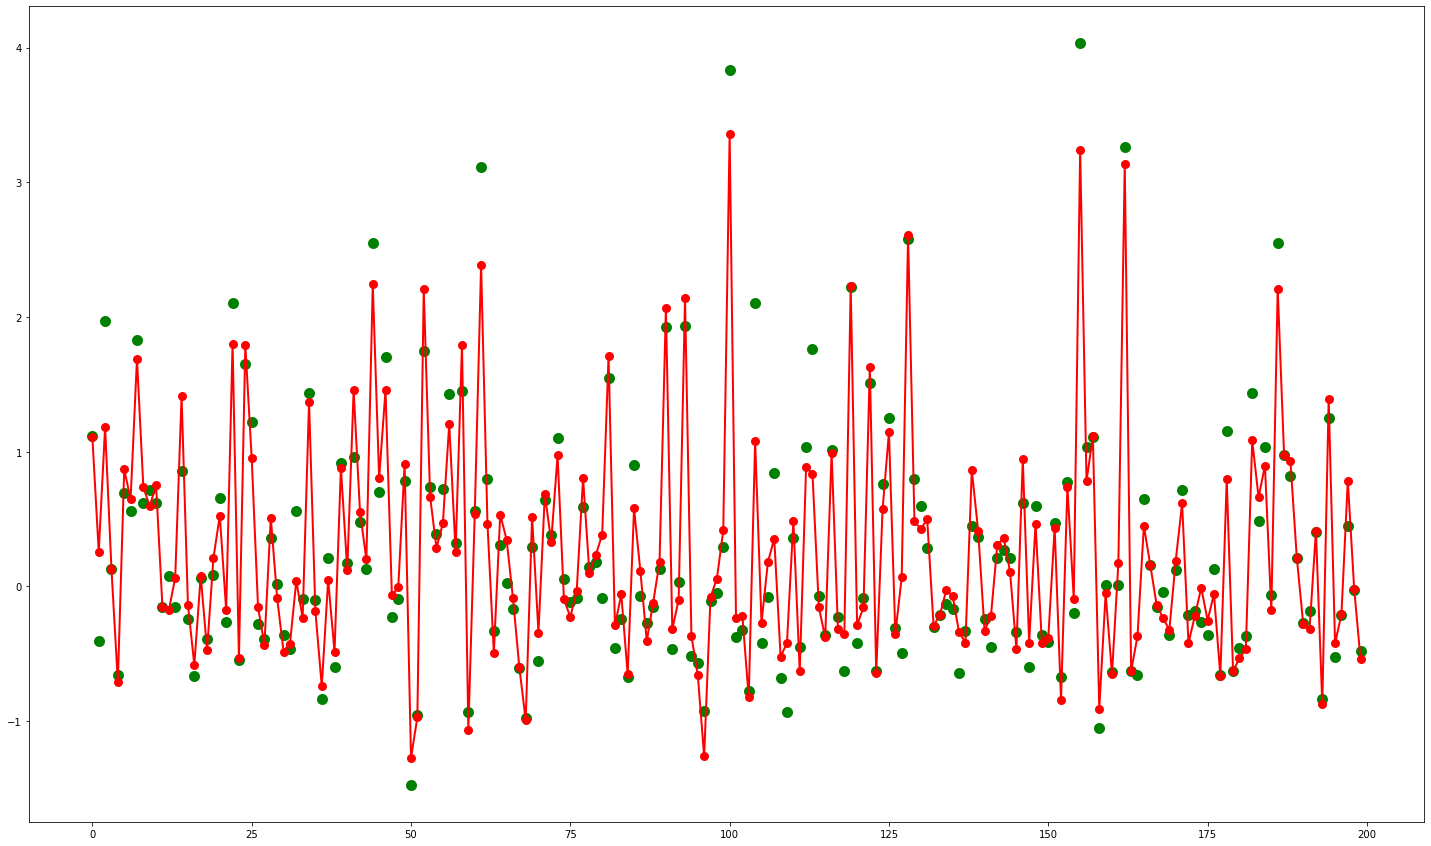

In [24]:
vr = VotingRegressor([('ridge', ridge), ('ridgecv', rcv), ('randomforest', rf), ('gradientboost', gbr), ('xgboost', xb), ('sr', sr)]).fit(X_train, y_train.ravel())

data_predicted = vr.predict(X_test)

MAX = 200
x = range(len(data_predicted))[0:MAX]
plt.scatter(x,y_test[0:MAX],color='g', linewidths=5)
plt.scatter(x,data_predicted[0:MAX],color='r', linewidths=3)
plt.plot(data_predicted[0:MAX], color = 'r', linewidth=2)

mse = mean_squared_error(y_test, data_predicted)
print("MSE: %.4f" % mse)

evs = explained_variance_score(y_test, data_predicted)
print("EVS: %.4f" % evs)

score = vr.score(X_test, y_test)
print("Score: %.4f" % score)

### Read Test data

In [25]:
data = pd.read_csv("house price test.csv")

In [26]:
data.head()
id_values = data.Id.values

### Replace the NaN values with mode

In [27]:
nonObjCols = data.select_dtypes(exclude=['object']).columns
for feature in nonObjCols:
    data[feature] = cleanNumericalData(data, feature)

In [28]:
data['MasVnrType'] = data['MasVnrType'].replace(np.nan, data.MasVnrType.value_counts().index[0])
data['Electrical'] = data['Electrical'].replace(np.nan, data.Electrical.value_counts().index[0])

### One-Hot Encoding

In [29]:
data = pd.get_dummies(data)

In [30]:
tcol = data.columns

### Identify missing features in test data, add them and set their values to zero

In [31]:
diffCols = [x for x in columns if x not in tcol]

data[diffCols] = 0

In [32]:
data = pd.DataFrame(data, columns = columns)

In [34]:
data.drop(['Price'], axis=1, inplace=True)

### Ensure there are no feature(s) with NaN values

In [35]:
for col in data.columns:
    if (data[col].isna().sum() > 0):
        print(col)

In [36]:
data = inScale.transform(data)

y = vr.predict(data)

Predicted_Values = outScale.inverse_transform(y.reshape(-1, 1))

Predicted_Values.shape

(1459, 1)

In [37]:
result = pd.DataFrame(id_values, columns=['Id'])

result['Price'] = Predicted_Values

result

,Id,Price
0,1461,118968.592567
1,1462,158778.570511
2,1463,182120.804989
3,1464,191281.774199
4,1465,191875.119709
...,...,...
1454,2915,85169.638827
1455,2916,85825.348361
1456,2917,170213.712565
1457,2918,111404.674335


In [38]:
result.to_csv("Result.csv", index=False)